In [ ]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2,970 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/g

In [ ]:
from __future__ import division

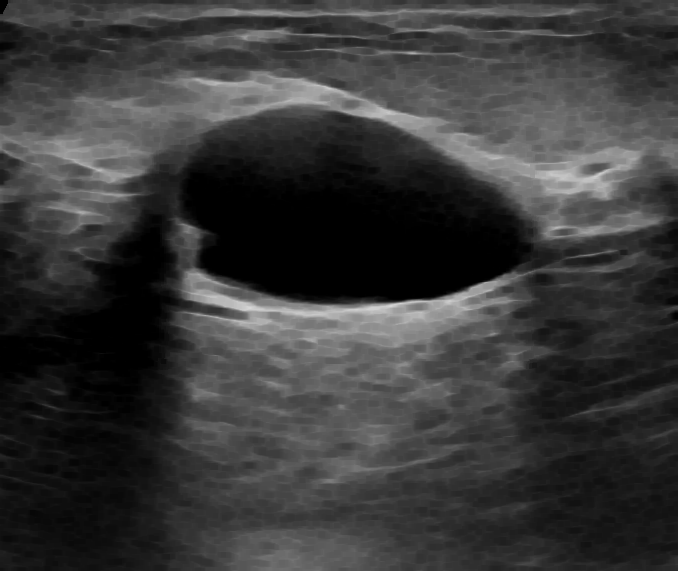

In [4]:
#Erosion
import cv2 as cv
import numpy as np
img = cv.imread('/content/benign (13).png',0)
kernel = np.ones((5,5),np.uint8)
erosion = cv.erode(img,kernel,iterations = 1)
cv2_imshow(erosion)

<ipython-input-5-9bb58c7eae59>:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread


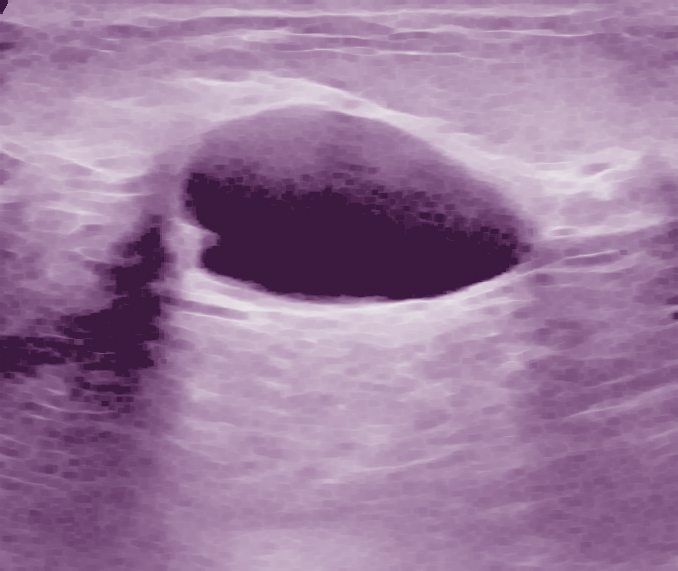

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

############### INPUT RGB IMAGE #######################
#Using opencv to read images may bemore robust compared to using skimage
#but need to remember to convert BGR to RGB.
#Also, convert to float later on and normalize to between 0 and 1.

#Image downloaded from:
#https://pbs.twimg.com/media/C1MkrgQWQAASbdz.jpg
img=cv2.imread("/content/benign (13).png", 1)
img = cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB)

Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


######## Step 1: Convert RGB to OD ###################
## reference H&E OD matrix.
#Can be updated if you know the best values for your image. 
#Otherwise use the following default values. 
#Read the above referenced papers on this topic. 
HERef = np.array([[0.5626, 0.2159],
                  [0.7201, 0.8012],
                  [0.4062, 0.5581]])
### reference maximum stain concentrations for H&E
maxCRef = np.array([1.9705, 1.0308])


# extract the height, width and num of channels of image
h, w, c = img.shape

# reshape image to multiple rows and 3 columns.
#Num of rows depends on the image size (wxh)
img = img.reshape((-1,3))
#cv2_imshow(img)

# calculate optical density
# OD = −log10(I)  
#OD = -np.log10(img+0.004)  #Use this when reading images with skimage
#Adding 0.004 just to avoid log of zero. 

OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread

ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
#Check by printing ODhat.min()

############# Step 3: Calculate SVD on the OD tuples ######################
#Estimate covariance matrix of ODhat (transposed)
# and then compute eigen values & eigenvectors.
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))


######## Step 4: Create plane from the SVD directions with two largest values ######
#project on the plane spanned by the eigenvectors corresponding to the two 
# largest eigenvalues    
That = ODhat.dot(eigvecs[:,1:3]) #Dot product

############### Step 5: Project data onto the plane, and normalize to unit length ###########
############## Step 6: Calculate angle of each point wrt the first SVD direction ########
#find the min and max vectors and project back to OD space
phi = np.arctan2(That[:,1],That[:,0])

minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)

vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


# a heuristic to make the vector corresponding to hematoxylin first and the 
# one corresponding to eosin second
if vMin[0] > vMax[0]:    
    HE = np.array((vMin[:,0], vMax[:,0])).T
    
else:
    HE = np.array((vMax[:,0], vMin[:,0])).T


# rows correspond to channels (RGB), columns to OD values
Y = np.reshape(OD, (-1, 3)).T

# determine concentrations of the individual stains
C = np.linalg.lstsq(HE,Y, rcond=None)[0]

# normalize stain concentrations
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])

###### Step 8: Convert extreme values back to OD space
# recreate the normalized image using reference mixing matrix 

Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm[Inorm>255] = 254
Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  

# Separating H and E components

H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
E[E>255] = 254
E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

cv2_imshow(Inorm)


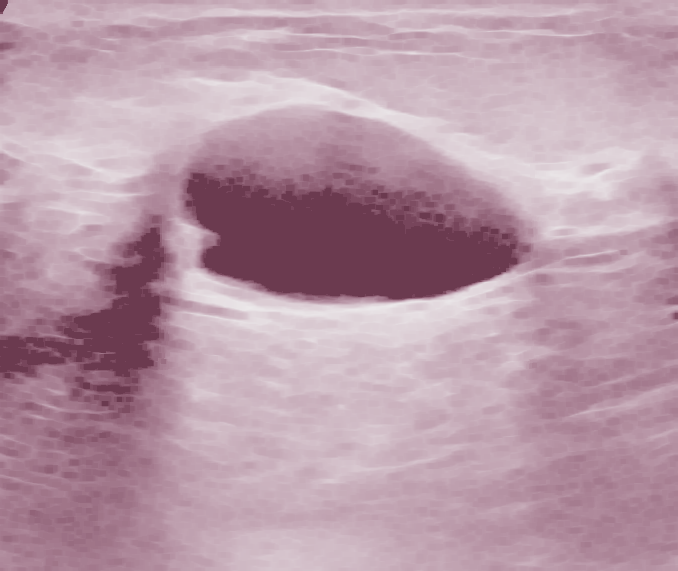

In [6]:

cv2_imshow(H)

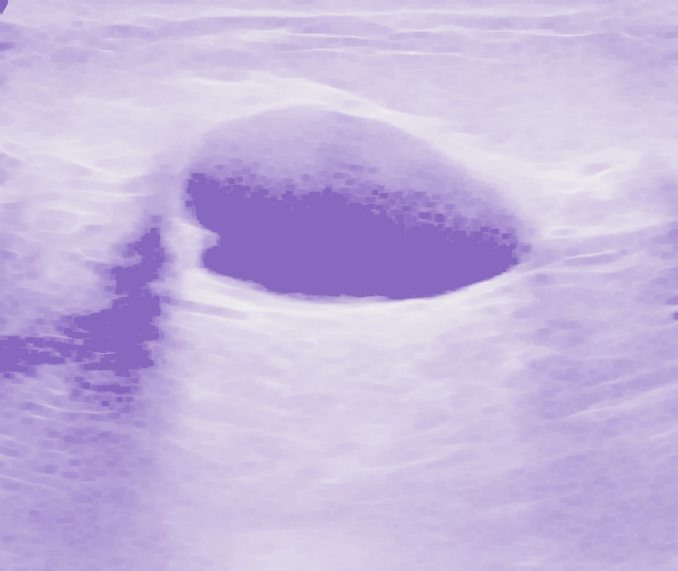

In [7]:

cv2_imshow(E)

In [8]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Load the image
#img = cv2.imread("/content/drive/MyDrive/Colon and lung cancer (histopathological)/colonca1.jpeg", cv2.IMREAD_GRAYSCALE)

# Load the image
#img = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)

# Perform Otsu's thresholding to binarize the image
_, binary_img = cv2.threshold(erosion, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Perform morphological operations to remove noise and fill the nuclei
kernel = np.ones((3,3),np.uint8)
opened_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
closed_img = cv2.morphologyEx(opened_img, cv2.MORPH_CLOSE, kernel, iterations=2)

# Perform connected component analysis to identify individual nuclei
connected_components, _ = cv2.connectedComponents(closed_img)

# Create a mask to highlight the nuclei
mask = np.zeros(img.shape, np.uint8)
for i in range(1, connected_components):
    mask[connected_components == i] = 255

# Overlay the nuclei mask on the original image
result = cv2.addWeighted(img, 0.7, mask, 0.3, 0)

# Save the segmented nuclei
cv2_imshow(result)

In [9]:
from google.colab.patches import cv2_imshow

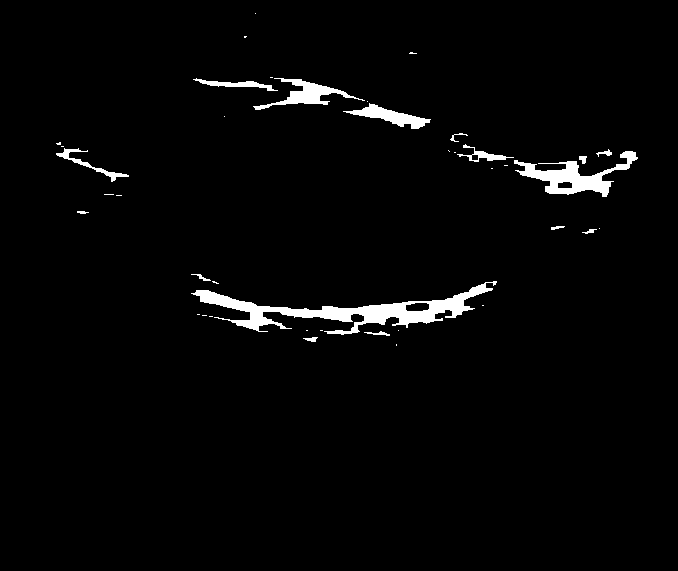

-1

In [10]:
import cv2
from google.colab.patches import cv2_imshow

 
# read the image
#image = cv2.imread("/content/drive/MyDrive/Colon and lung cancer (histopathological)/colonca1.jpeg")
img_gray = cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB)

ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
# visualize the binary image
cv2_imshow(thresh)
cv2.waitKey(0)


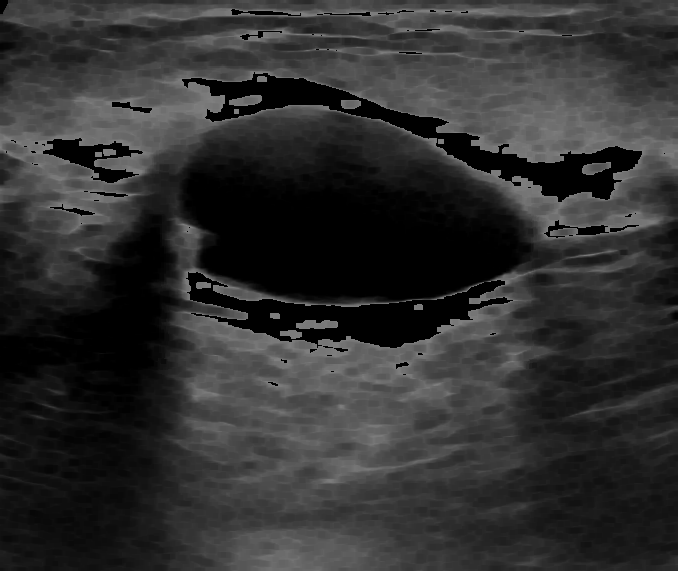

In [11]:
import cv2 
 
# Read image 
#src = cv2.imread("/content/drive/MyDrive/Colon and lung cancer (histopathological)/Himage.jpg", cv2.IMREAD_GRAYSCALE); 
 

 
# Thresholding using THRESH_TOZERO_INV 
th, dst = cv2.threshold(erosion,127,255, cv2.THRESH_TOZERO_INV); 
#cv2.imwrite("/content/sample_data/treshtozero.jpg", dst)
cv2_imshow(dst);

In [13]:

pip install git+https://github.com/lucasb-eyer/pydensecrf.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-01fiohoc
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-01fiohoc
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp38-cp38-linux_x86_64.whl size=3693212 sha256=2e8090e644f6e43a02ce2945c646dee3f3651382ad16928f7507b3fa3864036e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0_gtxyop/wheels/45/56/7a/826b4f5cd8459926ff5996ba9994fc36672487b6d2fa50d3d4
Successfully built pydensecrf


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from pydensecrf import densecrf

# Load image
#img = io.imread("/content/drive/MyDrive/Colon and lung cancer (histopathological)/Himage.jpg")
img = rgb2gray(erosion)

# Initialize dense CRF
d = densecrf.DenseCRF2D(img.shape[1], img.shape[0], 2)

# Set unary potentials
U = -np.log(np.array([0.8, 0.2])).astype(np.float32)
d.setUnaryEnergy(U)

# Set pairwise potentials
d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=densecrf.DIAG_KERNEL, normalization=densecrf.NORMALIZE_SYMMETRIC)

# Inference
Q = d.inference(5)

# Get segmentation result
segmentation = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))

# Plot result
plt.imshow(segmentation, cmap='gray')
plt.show()

<ipython-input-14-34ebe2e316de>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = rgb2gray(erosion)


ValueError: ignored

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def display(img, cmap = None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap = cmap)

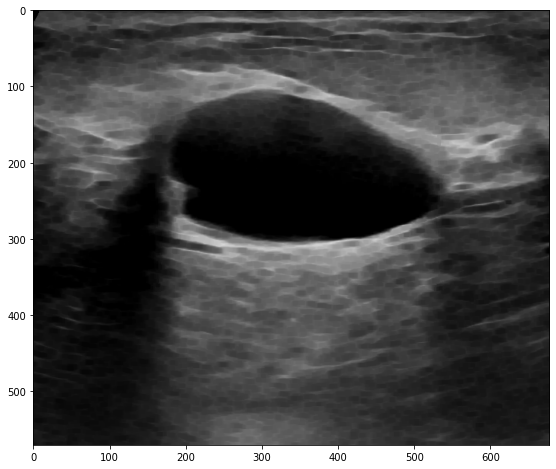

In [17]:
# load the image
img = cv2.imread('/content/opencv-thresh-to-zero-inv.jpg')
img = cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB)
display(img) 

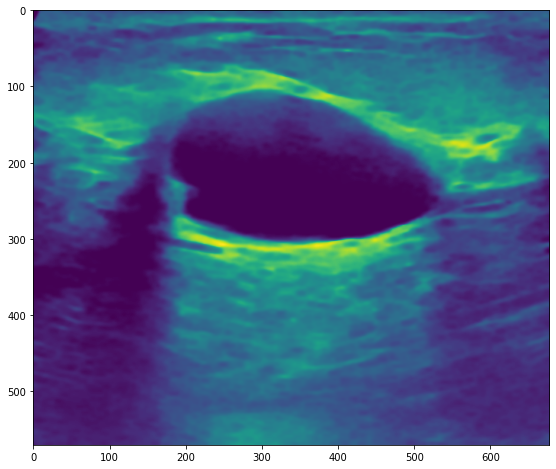

In [18]:
# Blurring for removing the noise 
img_blur = cv2.bilateralFilter(erosion, d = 7, 
                               sigmaSpace = 75, sigmaColor =75)
display(img_blur)

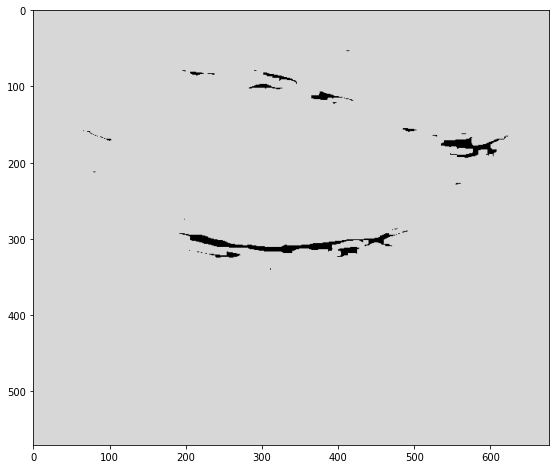

In [19]:
# Apply the thresholding  
a = img_gray.max()
_, thresh = cv2.threshold(img_gray, a/2+60, a, cv2.THRESH_BINARY_INV)
display(thresh, cmap = 'gray')

<ipython-input-21-d60f9ae972ca>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  sample_g = rgb2gray(erosion)


NameError: ignored

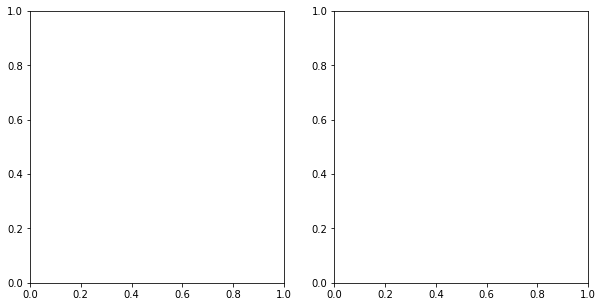

In [21]:
import numpy as np
from skimage.io import imshow, imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
#sample = imread('/content/image/opencv-thresh-to-zero-inv.jpg')
sample_g = rgb2gray(erosion)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sample)
ax[1].imshow(sample_g,cmap='gray')
ax[0].set_title('Colored Image',fontsize=15)
ax[1].set_title('Grayscale Image',fontsize=15)
plt.show()

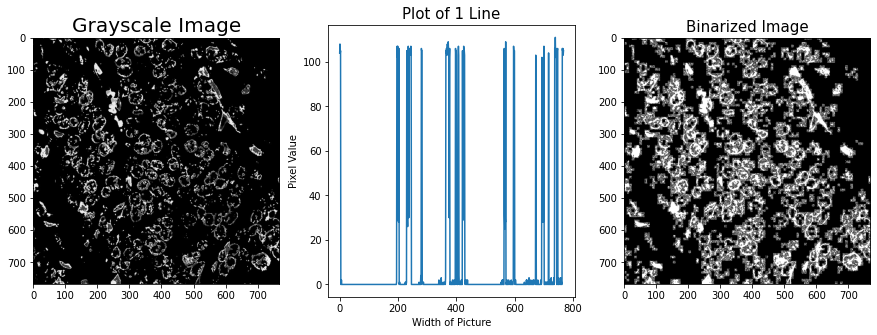

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
sample_b = sample_g > 0.6
ax[0].set_title('Grayscale Image',fontsize=20)
ax[0].imshow(sample_g,cmap='gray')
ax[1].plot(sample_g[600])
ax[1].set_ylabel('Pixel Value')
ax[1].set_xlabel('Width of Picture')
ax[1].set_title('Plot of 1 Line',fontsize=15)
ax[2].set_title('Binarized Image',fontsize=15)
ax[2].imshow(sample_b,cmap='gray')

In [ ]:
from stardist.models import StarDist2D 
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt
# prints a list of available models 
StarDist2D.from_pretrained() 

import os
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2 
from scipy import fftpack
from PIL import Image,ImageEnhance
import scipy.fftpack
from skimage import data, io
from scipy.signal import convolve2d as conv2



folder1 = r'C:\Users\HOME\Downloads\tcga_coad_msi_mss\train\kk\k'

dirr2 = r'C:\Users\HOME\Downloads\tcga_coad_msi_mss\train\kk\kk'
dirr3 = r'C:\Users\HOME\Downloads\tcga_coad_msi_mss\train\kk'



j=1


for im in os.listdir(folder1):
    
    #read image
    path = os.path.join(folder1,im)
    img = cv2.imread(path)
    HE_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    HE_model = StarDist2D.from_pretrained('2D_versatile_he')
    he_labels, _ = HE_model.predict_instances(normalize(HE_img))
    cv2.imwrite(os.path.join(dirr2,"seg1 " +str(j)+'.png'),he_labels)

    img2 = cv2.imread(os.path.join(dirr2,"seg1 " +str(j)+'.png'))
    k= cv2.bitwise_and(img,img2)

    cv2.imwrite(os.path.join(dirr3,"seg " +str(j)+'.png'),k)
    
    j=j+1

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
1/1 [==============================] - 1s 1s/step


In [ ]:
j=1


for im in os.listdir(folder1):
    
    #read image
    path = os.path.join(folder1,im)
    img = cv2.imread(path)
    HE_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    HE_model = StarDist2D.from_pretrained('2D_versatile_he')
    he_labels, _ = HE_model.predict_instances(normalize(HE_img))
    cv2.imwrite(os.path.join(dirr2,"seg1 " +str(j)+'.png'),he_labels)

    img2 = cv2.imread(os.path.join(dirr2,"seg1 " +str(j)+'.png'))
    k= cv2.bitwise_and(img,img2)

    cv2.imwrite(os.path.join(dirr3,"seg " +str(j)+'.png'),k)
    
    j=j+1

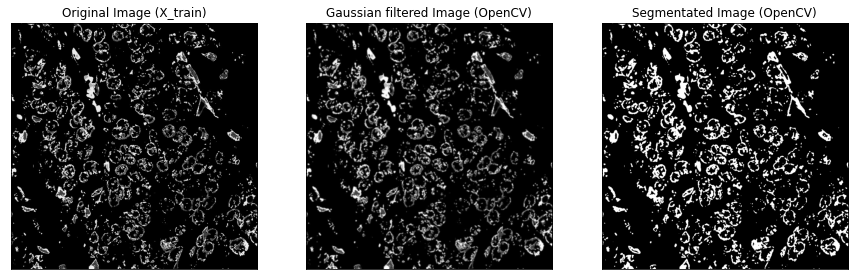

In [ ]:
def openCVdemo():
    ID = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
    FILE = "/content/image/opencv-thresh-to-zero-inv.jpg".format(ID,ID)
    img = cv2.imread(FILE,0)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)   
    # Plot Here
    plt.figure(figsize=(15,5))
    images = [blur, 0, th3]
    titles = ['Original Image (X_train)','Gaussian filtered Image (OpenCV)',"Segmentated Image (OpenCV)"]
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title(titles[0]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(images[0],'gray')
    plt.title(titles[1]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(images[2],'gray')
    plt.title(titles[2]), plt.xticks([]), plt.yticks([])
openCVdemo()


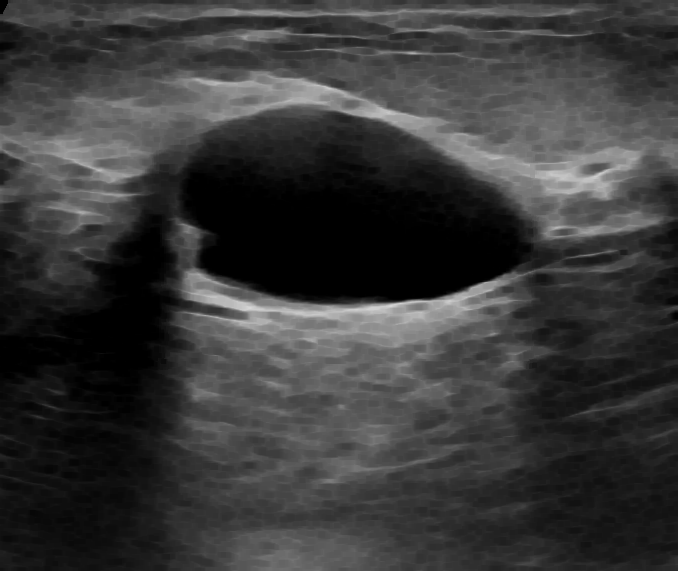

-1

In [22]:
import cv2
import numpy as np

# Load the image
#img = cv2.imread('/content/image/opencv-thresh-to-zero-inv.jpg', 0)

# Threshold the image to create a binary image
_, threshold = cv2.threshold(erosion, 128, 255, cv2.THRESH_BINARY)

# Use morphological operations to remove small objects
kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)

# Use morphological operations to fill the holes in the objects
opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)

# Show the output image
cv2_imshow(closing)
cv2.waitKey(0)

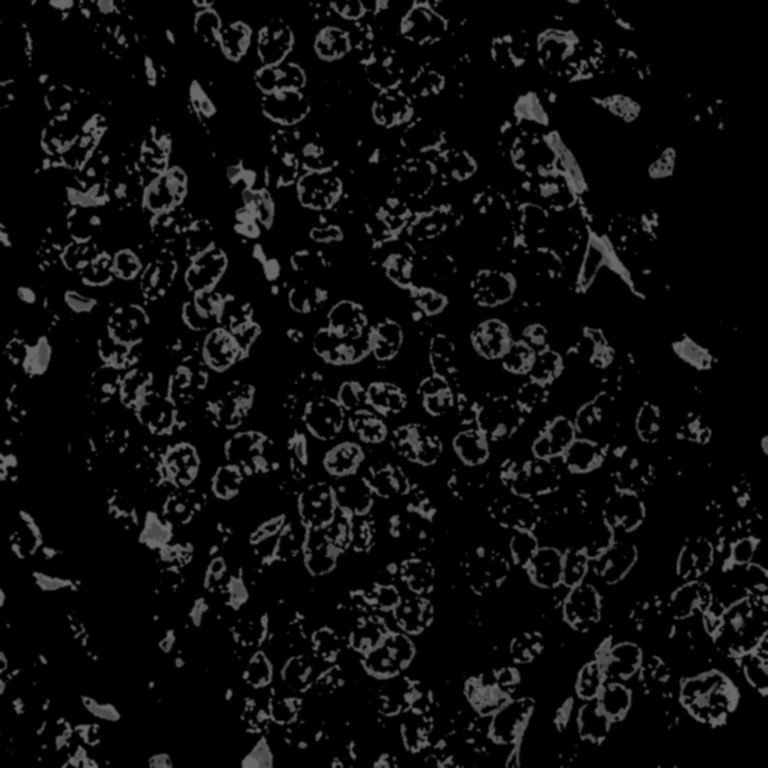

-1

In [ ]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('/content/sample_data/treshtozero.jpg')

# Apply Gaussian Blur to the image
blur = cv2.GaussianBlur(img, (5, 5), 0)

# Show the output image
cv2_imshow(blur)
cv2.waitKey(0)

In [23]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('/content/sample_data/treshtozero.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(erosion, cv2.COLOR_BGR2HSV)

# Define the range of color for the object to be removed
lower_color = np.array([0, 0, 0])
upper_color = np.array([179, 255, 60])

# Threshold the image to extract the object
mask = cv2.inRange(hsv, lower_color, upper_color)

# Perform morphological operations to remove the object
kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Invert the mask to get the remaining portion of the image
mask_inv = cv2.bitwise_not(mask)

# Use the mask to extract the remaining portion of the image
result1 = cv2.bitwise_and(img, img, mask=mask_inv)
#image= mask-result
# Show the output image
cv2_imshow(result1)
cv2.waitKey(0)






error: ignored

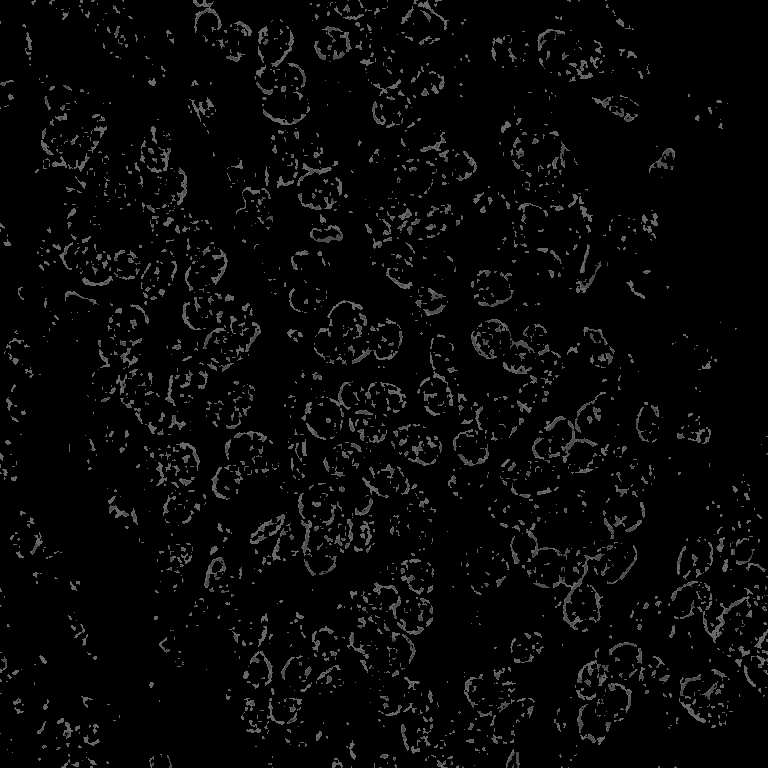

-1

In [ ]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('/content/sample_data/treshtozero.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the range of color for the object to be removed
lower_color = np.array([0, 0, 0])
upper_color = np.array([179, 255, 60])

# Threshold the image to extract the object
mask = cv2.inRange(hsv, lower_color, upper_color)

# Perform morphological operations to remove the object
kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Invert the mask to get the remaining portion of the image
mask_inv = cv2.bitwise_not(closing)

# Use the mask to extract the remaining portion of the image
result = cv2.bitwise_and(img, img, mask=mask_inv)
image= result1-result
# Show the output image
cv2_imshow(image)
cv2.waitKey(0)






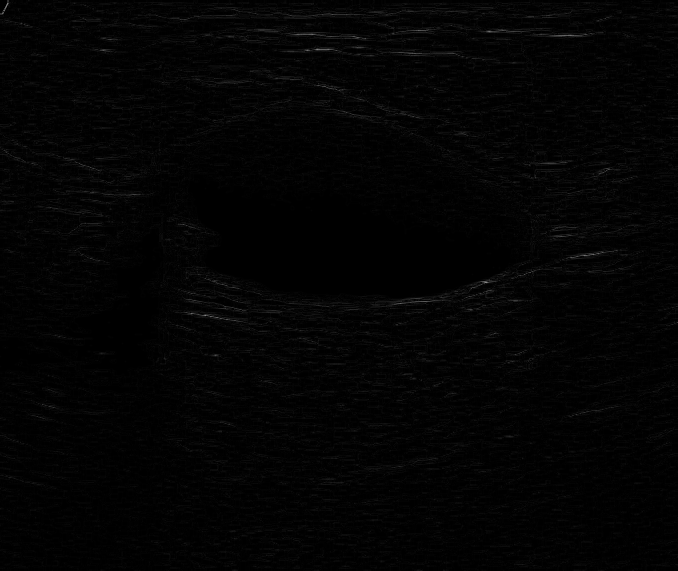

In [24]:
import cv2
import numpy as np


# Convert the image to grayscale
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply the Laplacian of Gaussian (LoG) filter
result = cv2.Laplacian(erosion, cv2.CV_64F)
result = np.uint8(np.absolute(result))

# Show the result
cv2_imshow(result)

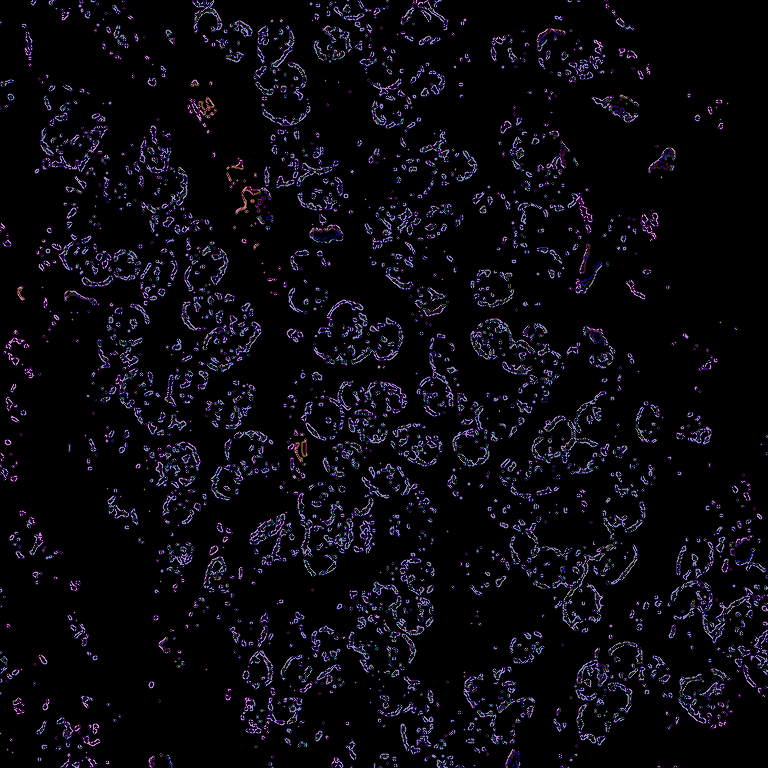

In [ ]:
import cv2
import numpy as np

# Load the image
img = cv2.imread("/content/benign (13).png")


# Perform the bitwise AND operation
res = cv2.bitwise_and(result, img)

# Show the result
cv2_imshow(res)
cv2.waitKey(0)
cv2.destroyAllWindows()

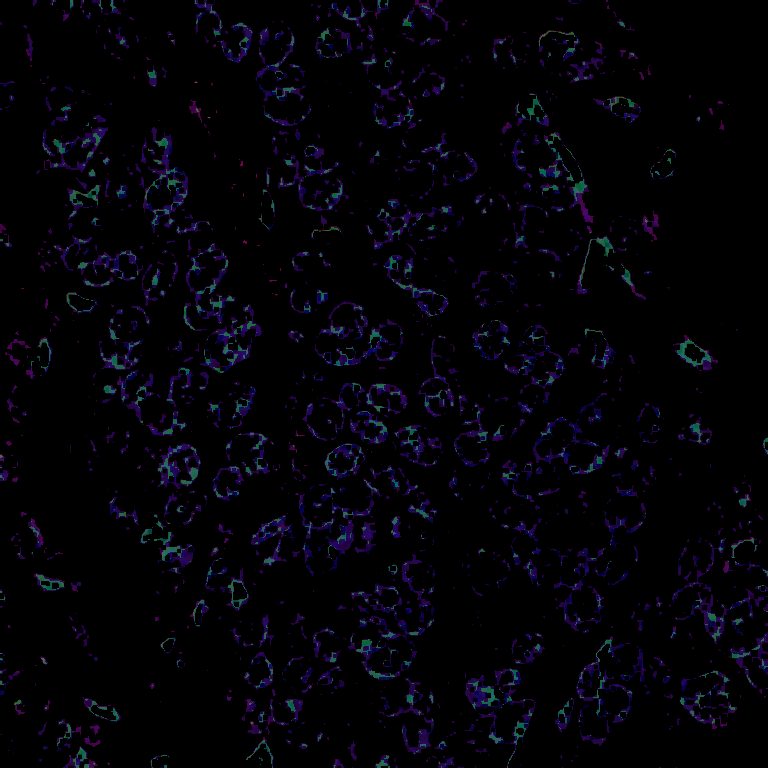

In [ ]:
kernel = np.ones((4,4), np.uint8)
closing = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel)
cv2_imshow(closing)

In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread("/content/drive/MyDrive/Colon and lung cancer (histopathological)/imageM.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 150)

# Create a copy of the image for the result
result = image.copy()

# Define a function for flood fill
def flood_fill(image, mask, seed, color, lo, hi):
    queue = [seed]
    while queue:
        y, x = queue.pop(0)
        if lo <= image[y, x] <= hi and mask[y, x] == 0:
            mask[y, x] = 1
            image[y, x] = color
            if y > 0:
                queue.append((y-1, x))
            if y < image.shape[0]-1:
                queue.append((y+1, x))
            if x > 0:
                queue.append((y, x-1))
            if x < image.shape[1]-1:
                queue.append((y, x+1))

# Apply flood fill for each connected component
mask = np.zeros(edges.shape, dtype=np.uint8)
label = 1
for y in range(edges.shape[0]):
    for x in range(edges.shape[1]):
        if edges[y, x] == 255 and mask[y, x] == 0:
            flood_fill(result, mask, (y, x), (255, 0, 0), 50, 150)

# Show the result
cv2_imshow(result)
cv2.waitKey(0)
cv2.destroyAllWindows()

ValueError: ignored

In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image, ImageDraw
  
# Opening the image (R prefixed to
# string in order to deal with '\'
# in paths)
img = Image.open("/content/drive/MyDrive/Colon and lung cancer (histopathological)/imageM.jpg")
 
# Converting the image to RGB mode
#img1 = img.convert("RGB")
 
# Coordinates of the pixel whose value
# would be used as seed
seed = (263, 70)
  
# Pixel Value which would be used for
# replacement
rep_value = (255, 255, 0)
  
# Calling the floodfill() function and
# passing it image, seed, value and
# thresh as arguments
ImageDraw.floodfill(img, seed, rep_value, thresh=50)

==============================

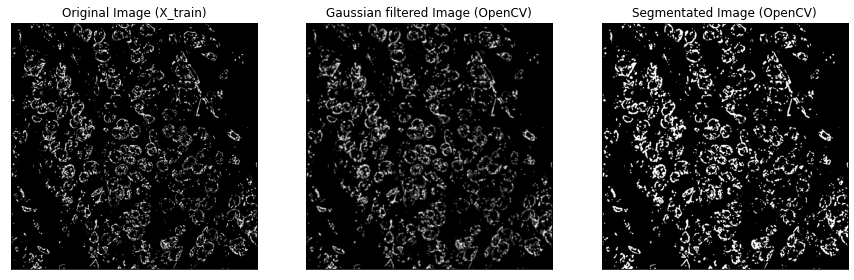

In [ ]:
def openCVdemo():
    ID = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
    FILE = "/content/download (2).png".format(ID,ID)
    img = cv2.imread(FILE,0)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)   
    # Plot Here
    plt.figure(figsize=(15,5))
    images = [blur, 0, th3]
    titles = ['Original Image (X_train)','Gaussian filtered Image (OpenCV)',"Segmentated Image (OpenCV)"]
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title(titles[0]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(images[0],'gray')
    plt.title(titles[1]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(images[2],'gray')
    plt.title(titles[2]), plt.xticks([]), plt.yticks([])
openCVdemo()

========================

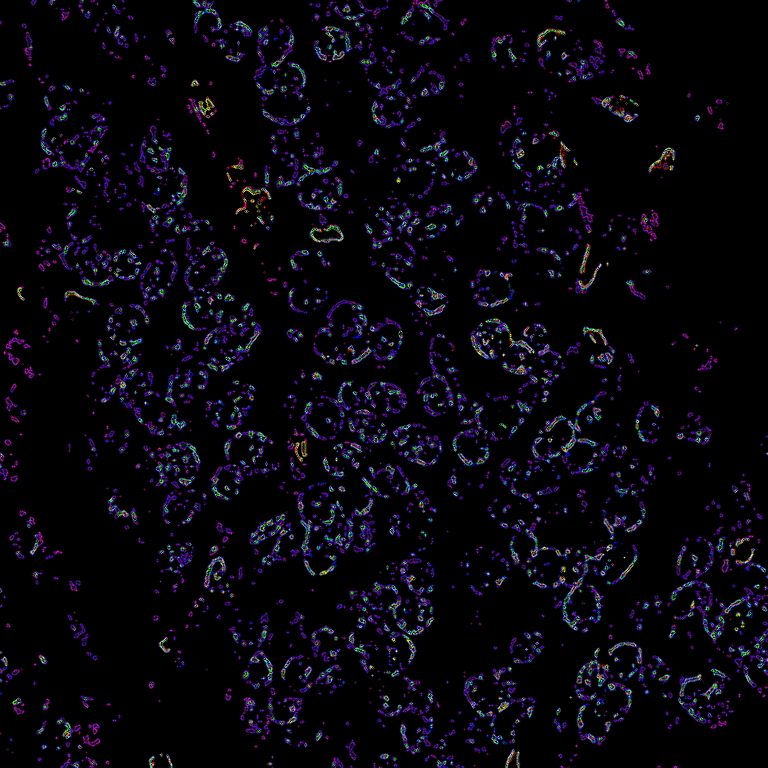

In [ ]:
import cv2
import numpy as np


# Convert the image to grayscale
gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

# Apply the Laplacian of Gaussian (LoG) filter
result = cv2.Laplacian(res, cv2.CV_64F)
result = np.uint8(np.absolute(result))

# Show the result
cv2_imshow(result)

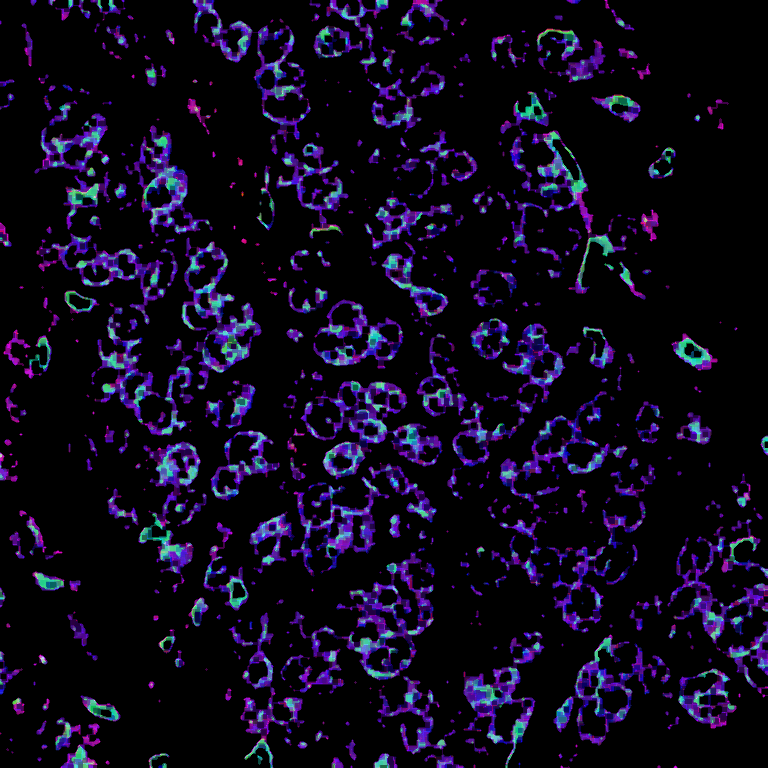

In [ ]:
import cv2 as cv
import numpy as np
#img = cv.imread('j.png',0)
kernel = np.ones((5,5),np.uint8)
opening = cv.morphologyEx(result, cv.MORPH_CLOSE, kernel)
cv2_imshow(opening)

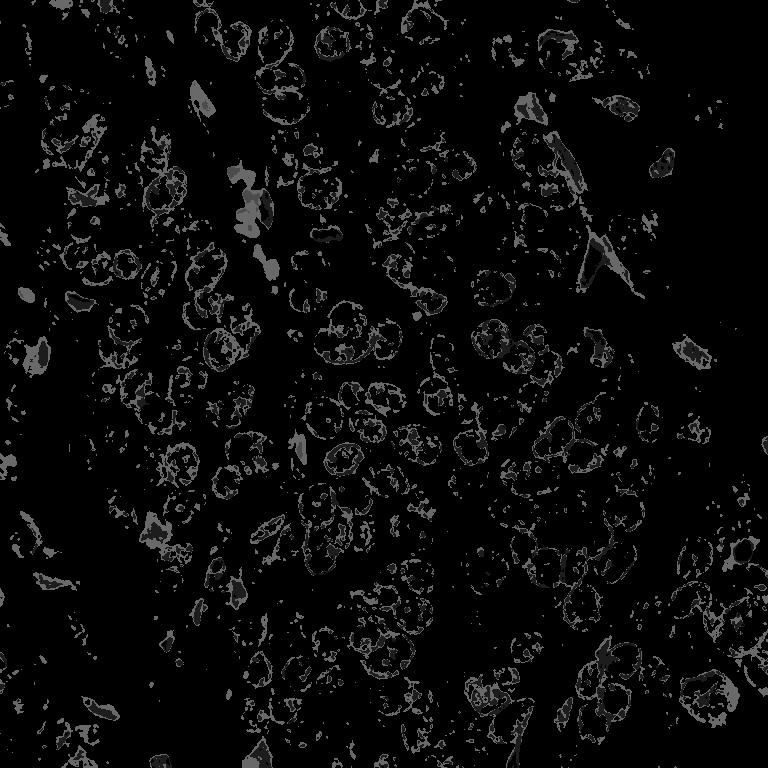

-1

In [ ]:
import cv2
import numpy as np

# Load the image
#img = cv2.imread('image.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image
_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

# Find the contours in the thresholded image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image
result = img.copy()

# Loop over the contours and draw a filled rectangle for each one
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(result, (x, y), (x + w, y + h), (0, 0, 255), -1)

# Show the output image
cv2_imshow(result)
cv2.waitKey(0)

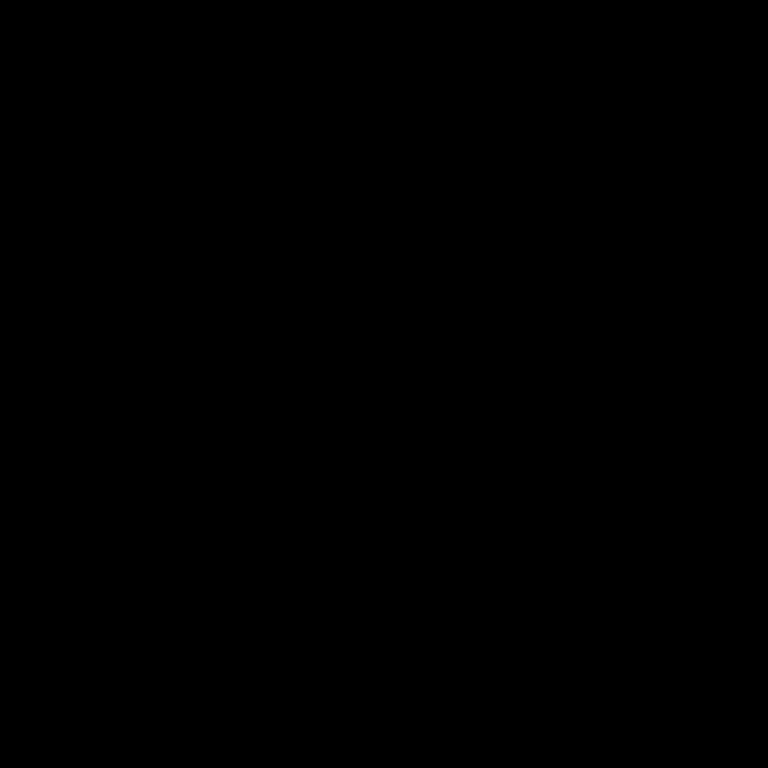

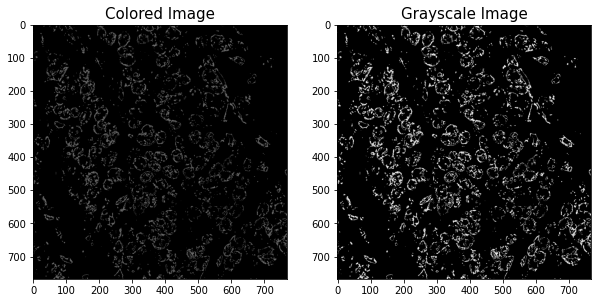

In [ ]:
import numpy as np
from skimage.io import imshow, imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
#sample = imread('/content/opencv-thresh-to-zero-inv.jpg')
sample_g = rgb2gray(image)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image)
ax[1].imshow(sample_g,cmap='gray')
ax[0].set_title('Colored Image',fontsize=15)
ax[1].set_title('Grayscale Image',fontsize=15)

cv2_imshow(sample_g)

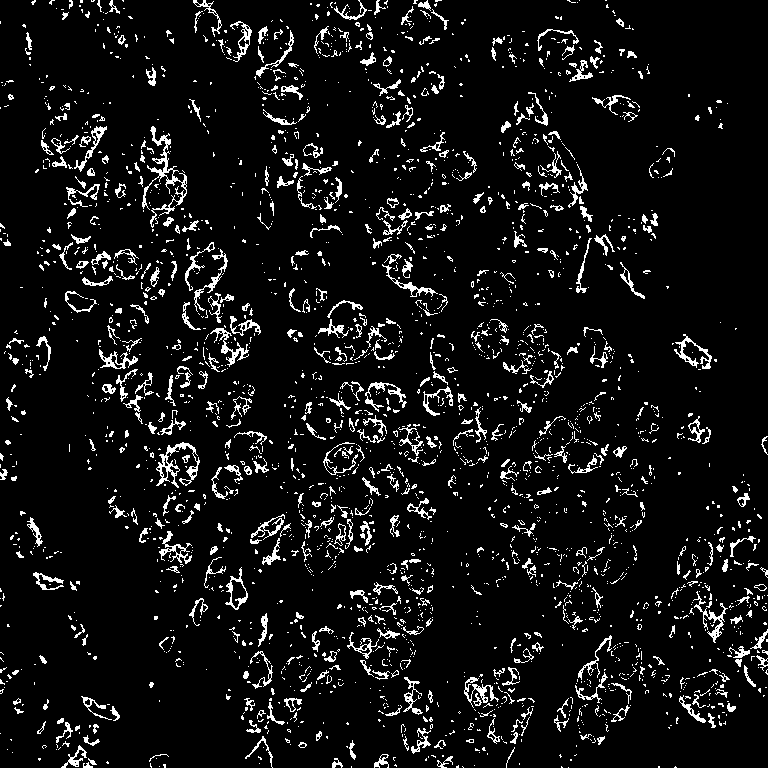

In [ ]:
import cv2

# load the input image
#img = cv2.imread('architecture1.jpg')

# convert the input image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# apply thresholding to convert grayscale to binary image
ret,thresh = cv2.threshold(gray,70,255,0)

# Display the Binary Image
cv2_imshow(thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

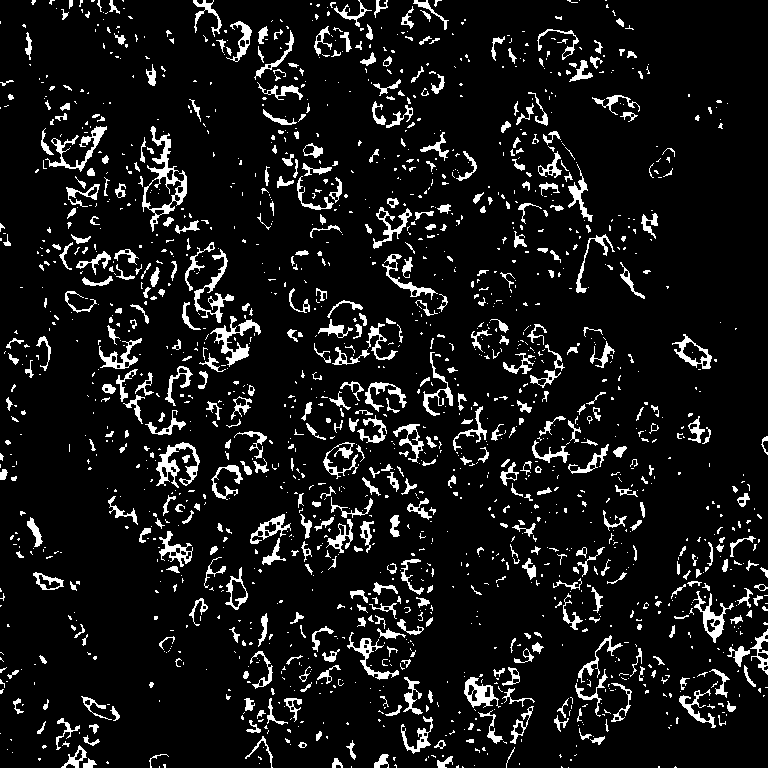

In [ ]:
kernel = np.ones((3, 3), np.uint8)

# Perform morphological closing
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)


cv2_imshow(closing)

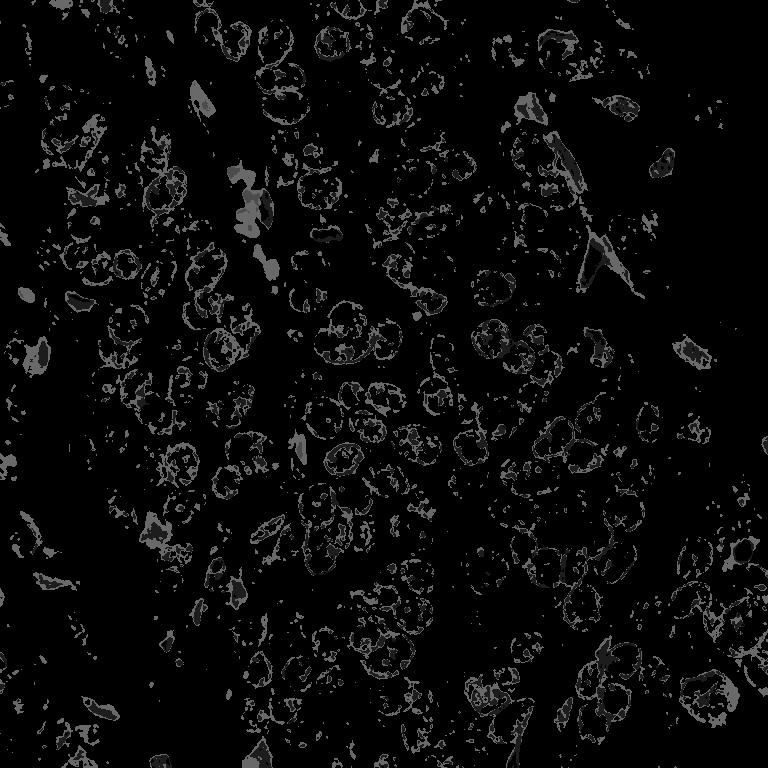

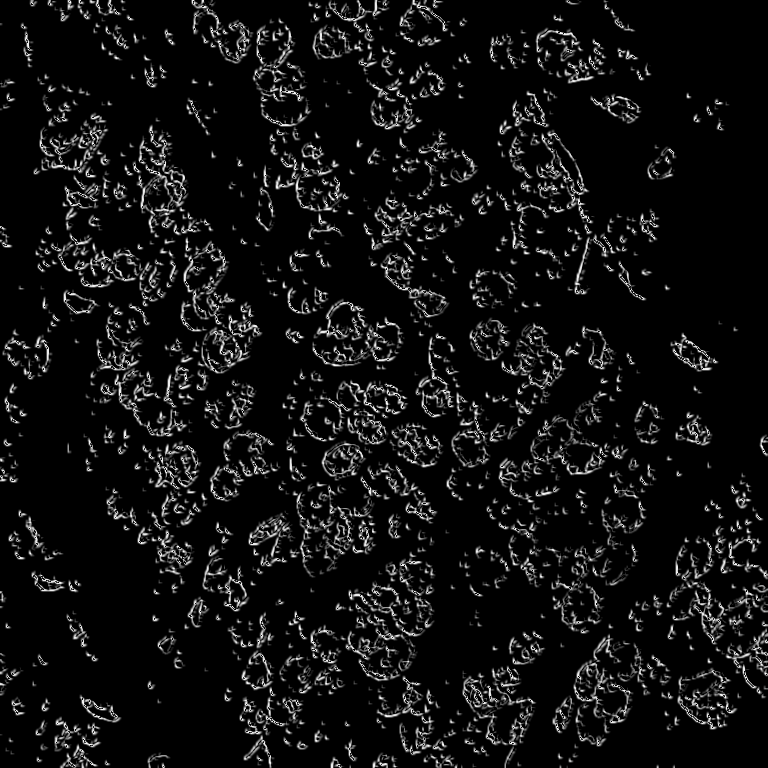

In [ ]:

import cv2
import numpy as np

img = cv2.imread('/content/image/opencv-thresh-to-zero-inv.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_gaussian = cv2.GaussianBlur(gray,(3,3),0)

#canny
img_canny = cv2.Canny(img,100,200)

#sobel
img_sobelx = cv2.Sobel(img_gaussian,cv2.CV_8U,1,0,ksize=5)
img_sobely = cv2.Sobel(img_gaussian,cv2.CV_8U,0,1,ksize=5)
img_sobel = img_sobelx + img_sobely


#prewitt
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
img_prewittx = cv2.filter2D(img_gaussian, -1, kernelx)
img_prewitty = cv2.filter2D(img_gaussian, -1, kernely)


cv2_imshow(img)

cv2_imshow(img_prewittx + img_prewitty)


cv2.waitKey(0)
cv2.destroyAllWindows()

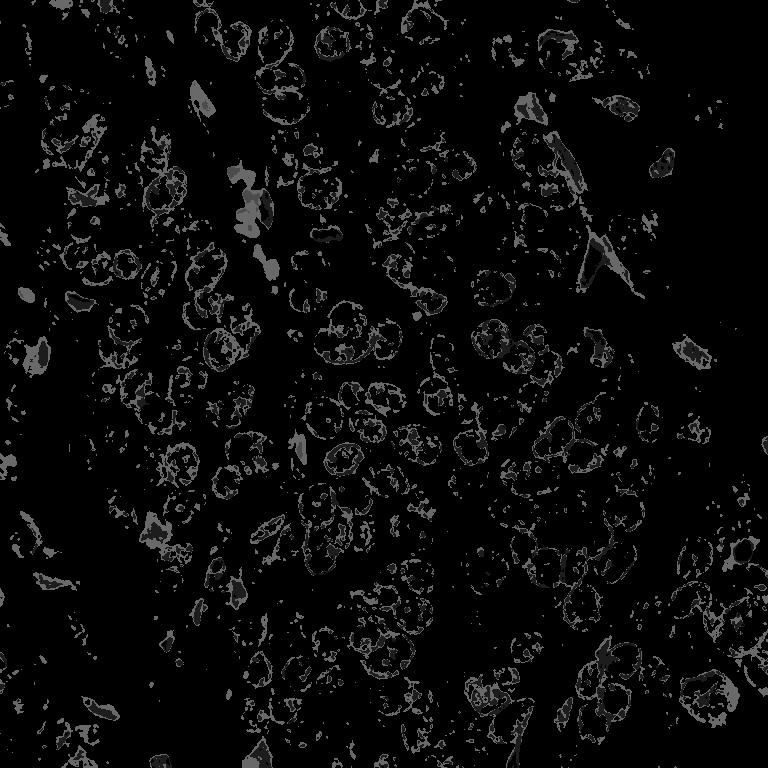

-1

In [ ]:
import cv2
import numpy as np

# Load the image
#img = cv2.imread('image.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds of the color you want to mask
lower_bound = np.array([0, 0, 0])
upper_bound = np.array([255, 255, 150])

# Create a binary mask using the bounds
mask = cv2.inRange(hsv, lower_bound, upper_bound)

# Apply the mask to the image
result = cv2.bitwise_and(img, img, mask=mask)

# Show the result
cv2_imshow(result)
cv2.waitKey(0)

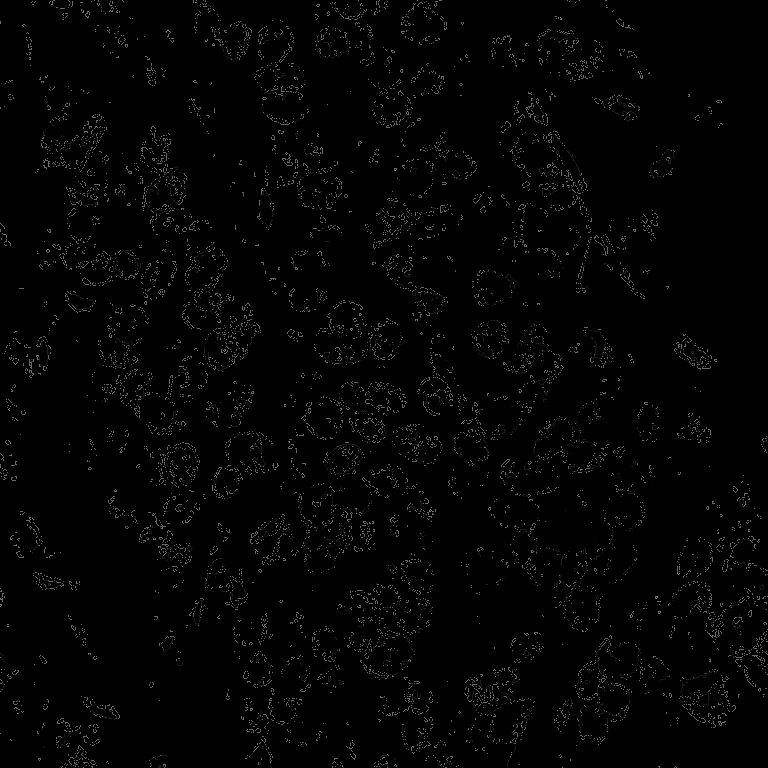

In [ ]:
import cv2
import numpy as np

# Load the image
#img = cv2.imread('image.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect edges using the Canny edge detection algorithm
edges = cv2.Canny(gray, 100, 200)

# Create a binary mask using the edges
mask = np.zeros_like(gray)
mask[edges != 0] = 255

# Apply the mask to the image
result = cv2.bitwise_and(img, img, mask=mask)

# Show the result
cv2_imshow(result)

In [ ]:
##Github 
img= cv2.imread("/content/image/opencv-thresh-to-zero-inv.jpg")
im_patch=np.array(img)

 
# data
print(im_patch)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
